<a href="https://colab.research.google.com/github/michalprusek/SU1-z-po-et/blob/main/100_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The Goal


Cílem tohoto projektu je klasifikovat mou rukou psané číslice.

Ke klasifikaci využívám fúzi tří modelů - kNN, SVM, Random Forest.

Příznaky jsou vytvořeny pomocí Fourierových deskriptorů kontur jednotlivých číslic. Je ponecháno prvních 30. Jednotlivé Fourierovy deskriptory jsou ve formě komplexních čísel. Tudíž vzniká celkem 60-dimenzionální příznakový prostor.

Výsledkem je pak program, který na základě poskytnuté sekvence rukou napsaných číslic dokáže tyto číslice rozpoznat a převést na pole znaků.

## Code

### Dataset

Dataset obsahuje celkem 10 tříd (číslice od 0 do 9). Pro každou třídu se v datasetu nachází přibližně 800 vzorků (obrázků číslice). Ukázky číslic z datasetu vypadají následovně:

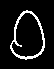
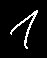
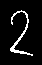
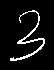
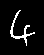
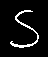
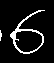
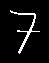
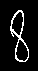
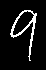

dataset k dispozici na: [github - dataset](https://github.com/michalprusek/SU1-z-po-et/tree/main)

Zároveň součástí datasetu jsou i napočítané Fourierovy deskriptory, celého datasetu uložené do npy souboru.




## Code

### Imports

In [1]:
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import sys

In [10]:

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
 !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
 !apt-get update -qq 2>&1 > /dev/null
 !apt-get -y install -qq google-drive-ocamlfuse fuse



IndentationError: ignored

###kNN Class

In [2]:
class kNN:
    def __init__(self, kNeighbours, X_train, y_train):
        self.k = kNeighbours
        self.X_train = X_train
        self.y_train = y_train
        self.y_predicted = []


    def predict(self, X_test):
        distances = np.zeros((self.X_train.shape[0]))
        for seq in X_test:
            for i in range(distances.shape[0]):
                mensi = min(len(seq), len(self.X_train[i]))
                norma = np.linalg.norm(seq[:mensi] - self.X_train[i][:mensi])

                distances[i] = norma


            kNNGestures = []
            for i in range(self.k):
                argMin = np.argmin(distances)
                kNNGestures.append(self.y_train[argMin])
                distances[argMin] = np.max(distances)

            b = Counter(kNNGestures)

            vyherniGesto = b.most_common(1)[0][0]

            self.y_predicted.append(vyherniGesto)

        return self.y_predicted

    def metrics(self, y_test):
        print(confusion_matrix(self.y_predicted, y_test))
        print(classification_report(self.y_predicted, y_test))

### SVM Class

In [3]:
class SVM:
    def __init__(self, X_train, y_train):
        self.X_train = self.separate_real_imaginary_list(X_train)
        self.y_train = y_train
        self.y_predicted = None

    def fit(self):
        self.svm_classifier = SVC(kernel='rbf', gamma='scale', decision_function_shape='ovr')  # OvR strategy
        self.svm_classifier.fit(self.X_train, self.y_train)

    def predict(self,  X_test):
        X_test = self.separate_real_imaginary_list(X_test)
        self.y_predicted = self.svm_classifier.predict(X_test)
        return self.y_predicted

    def metrics(self, y_test):
        print(confusion_matrix(self.y_predicted, y_test))
        print(classification_report(self.y_predicted, y_test))

    def separate_real_imaginary_list(self, descriptors):
        feature_vectors = []
        for seq in descriptors:
            real_parts = np.real(seq)
            imaginary_parts = np.imag(seq)
            feature_vectors.append(np.concatenate((real_parts, imaginary_parts)))

        return feature_vectors

### Random Forest Class

In [4]:
class RandomForest:
    def __init__(self, X_train, y_train):
        self.X_train = self.separate_real_imaginary_list(X_train)
        self.y_train = y_train
        self.y_predicted = None

    def fit(self):
        self.rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        self.rf_classifier.fit(self.X_train, self.y_train)

    def predict(self, X_test):
        X_test = self.separate_real_imaginary_list(X_test)
        self.y_predicted = self.rf_classifier.predict(X_test)
        return self.y_predicted

    def metrics(self, y_test):
        print(confusion_matrix(self.y_predicted, y_test))
        print(classification_report(self.y_predicted, y_test))

    def separate_real_imaginary_list(self, descriptors):
        feature_vectors = []
        for sequence in descriptors:
            real_parts = np.real(sequence)
            imaginary_parts = np.imag(sequence)
            feature_vectors.append(np.concatenate((real_parts, imaginary_parts)))

        return feature_vectors

### Other Functions

In [5]:
def winners(knn_predicted, svm_predicted, rf_predicted):
  if len(knn_predicted) == len(svm_predicted) == len(rf_predicted):
    winners_array = []
    for i in range(len(rf_predicted)):
        arr = [knn_predicted[i], svm_predicted[i], rf_predicted[i]]
        b = Counter(arr)

        winner = b.most_common(1)[0][0]
        winners_array.append(winner)

    return winners_array
  else:
    print("pole nemají stejnou délku")
    sys.exit()


def metrics(y_predicted, y_test):
    print(confusion_matrix(y_predicted, y_test))
    print(classification_report(y_predicted, y_test))



def winners_testing(knn_predicted, svm_predicted, rf_predicted):
    if len(knn_predicted) == len(svm_predicted) == len(rf_predicted):
        winners_array = []
        for i in range(len(rf_predicted)):
            arr = [knn_predicted[i], svm_predicted[i], rf_predicted[i]]
            b = Counter(arr)

            winner = b.most_common(1)[0][0]
            winners_array.append(winner)

        return winners_array
    else:
        print("pole nemají stejnou délku")
        sys.exit()

def fourier_descriptors(contour, num):
    contour_complex = contour[:, 0, 0] + contour[:, 0, 1] * 1j

    ft_contour = np.fft.fft(contour_complex)
    fd = ft_contour[1:num + 1] / (len(ft_contour) ** 2)
    return fd

### Main Script - Accuracy

In [8]:
file = np.load("drive/Colab Notebooks/FD.npy", encoding='bytes', allow_pickle=True)

deskriptory = file[0]
cislice = file[1]

X_train, X_test, y_train, y_test = train_test_split(deskriptory, cislice, test_size=0.2, random_state=42)

FileNotFoundError: ignored

kNN - Accuracy

In [ ]:
knn = kNN.kNN(7, X_train, y_train)
knn_predicted = knn.predict(X_test)
knn.metrics()

SVM - Accuracy

In [ ]:
svm = SVM.SVM(X_train, y_train)
svm.fit()
svm_predicted = svm.predict(X_test)
svm.metrics()

Random Forest - Accuracy

In [ ]:
rf = RandomForest.RandomForest(X_train, y_train)
rf.fit()
rf_predicted = rf.predict(X_test)
rf.metrics()

Fúze - Accuracy

In [ ]:
y_predicted = winners(knn_predicted, svm_predicted, rf_predicted)
metrics(y_predicted, y_test)

### Main Script - Real Testing

In [ ]:
    pocet_des = 30
    img = cv.imread("/Users/michalprusek/Desktop/SU1 - cislice/TEST/TEST.png")

    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    drawing = np.zeros(np.shape(img), np.uint8)

    img[img >= 127] = 255
    img[img < 127] = 0
    img = np.invert(img)

    contours, hierarchy = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    sorted_contours = sorted(contours, key=lambda ctr: cv.boundingRect(ctr)[0])

    FD_array = []
    for contour in sorted_contours:
        FD = fourier_descriptors(contour, pocet_des)
        FD_array.append(FD)

    knn_predicted = knn.predict(FD_array)

    svm_predicted = svm.predict(FD_array)

    rf_predicted = rf.predict(FD_array)

    y_predicted = winners_testing(knn_predicted, svm_predicted, rf_predicted)

    print(y_predicted)

    for contour in sorted_contours:
        cv.drawContours(drawing, [contour], -1, (255, 255, 255), 2)

    cv.imshow("img", drawing)
    cv.waitKey(0)

## Discuss the results

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.